<a href="https://colab.research.google.com/github/eswens13/cs6955/blob/dev/hw3/homework3_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with RNNs
In this exercise you will implement a vanilla recurrent neural networks and use them it to train a model that can generate novel captions for images.

In [0]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import h5py
import urllib
import tempfile
from scipy.misc import imread

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

  
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


# Microsoft COCO
For this exercise we will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

The data for this assignment is located in Google Drive.  Click on [this link](https://drive.google.com/open?id=1aCwJhv_33XKfLm-rIcZ6l56CraubacEU), then right-click the `uu_deep_learning_data` directory and choose "Add to My Drive".

We have preprocessed the data and extracted features for you already. For all images we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet; these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5` respectively. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512; these features can be found in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`.

The raw images take up a lot of space (nearly 20GB) so we have not included them in the download. However all images are taken from Flickr, and URLs of the training and validation images are stored in the files `train2014_urls.txt` and `val2014_urls.txt` respectively. This allows you to download images on the fly for visualization. Since images are downloaded on-the-fly, **you must be connected to the internet to view images**.

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` to convert numpy arrays of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

You can load all of the MS-COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function. Run the following cell to do so:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DRIVE_DIR = '/content/drive/My Drive/uu_deep_learning_data/coco_captioning'

def load_coco_data(base_dir=DRIVE_DIR,
                   max_train=None,
                   pca_features=True):
    data = {}
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    with h5py.File(caption_file, 'r') as f:
        for k, v in f.items():
            data[k] = np.asarray(v)

    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        data['train_features'] = np.asarray(f['features'])

    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])

    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls

    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)
        data['train_captions'] = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]

    return data


In [5]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function and that we download the images on-the-fly using their Flickr URL, so **you must be connected to the internet to view images**.

In [0]:
def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded


def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data['%s_captions' % split][mask]
    image_idxs = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    urls = data['%s_urls' % split][image_idxs]
    return captions, image_features, urls

  
def image_from_url(url):
    """
    Read an image from a URL. Returns a numpy array with the pixel data.
    We write the image to a temporary file then read it back. Kinda gross.
    """
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, 'wb') as ff:
            ff.write(f.read())
        img = imread(fname)
        os.remove(fname)
        return img
    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url)

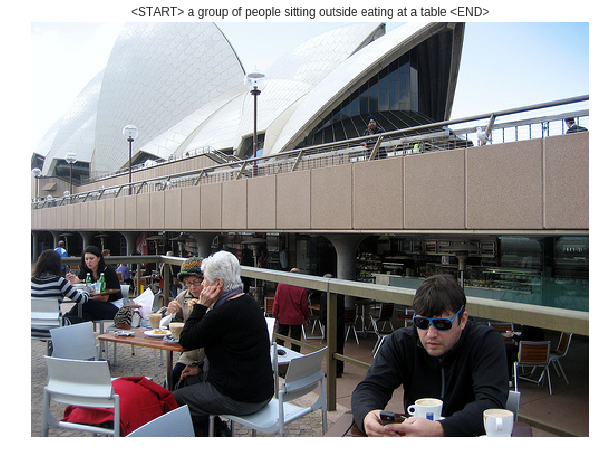

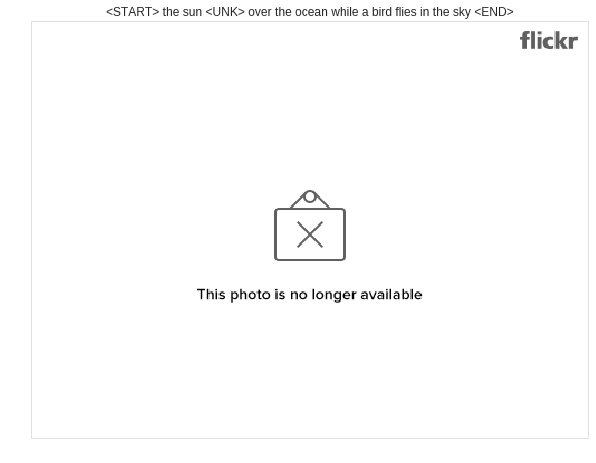

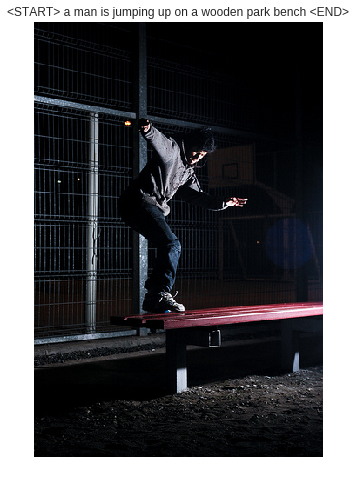

In [7]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use recurrent neural network (RNN) language models for image captioning. Below we implement different layer types that are needed for recurrent neural networks.

# Vanilla RNN: step forward
First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors on the order of e-8 or less.

In [0]:
def rnn_step_forward(x, prev_h, wx, wh, b):
    """
    run the forward pass for a single timestep of a vanilla rnn that uses a tanh
    activation function.

    the input data has dimension d, the hidden state has dimension h, and we use
    a minibatch size of n.

    inputs:
    - x: input data for this timestep, of shape (n, d).
    - prev_h: hidden state from previous timestep, of shape (n, h)
    - wx: weight matrix for input-to-hidden connections, of shape (d, h)
    - wh: weight matrix for hidden-to-hidden connections, of shape (h, h)
    - b: biases of shape (h,)

    returns a tuple of:
    - next_h: next hidden state, of shape (n, h)
    - cache: tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # todo: implement a single forward step for the vanilla rnn. store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    ##############################################################################
    
    # Calculate the next hidden state.
    next_h = np.tanh(np.dot(x, wx) + np.dot(prev_h, wh) + b);
    
    # Cache off values that are important for gradient calculations.
    cache = {}
    cache['tanh_out'] = next_h
    cache['x'] = x
    cache['wx'] = wx
    cache['h'] = prev_h
    cache['wh'] = wh
    
    ##############################################################################
    #                               end of your code                             #
    ##############################################################################
    return next_h, cache

In [9]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward
Implement the `rnn_step_backward` function. After doing so run the following to numerically gradient check your implementation. You should see errors on the order of `e-8` or less.

In [0]:
def rnn_step_backward(dnext_h, cache):
    """
    backward pass for a single timestep of a vanilla rnn.

    inputs:
    - dnext_h: gradient of loss with respect to next hidden state, of shape (n, h)
    - cache: cache object from the forward pass

    returns a tuple of:
    - dx: gradients of input data, of shape (n, d)
    - dprev_h: gradients of previous hidden state, of shape (n, h)
    - dwx: gradients of input-to-hidden weights, of shape (d, h)
    - dwh: gradients of hidden-to-hidden weights, of shape (h, h)
    - db: gradients of bias vector, of shape (h,)
    """
    dx, dprev_h, dwx, dwh, db = None, None, None, None, None
    ##############################################################################
    # todo: implement the backward pass for a single step of a vanilla rnn.      #
    #                                                                            #
    # hint: for the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################
    
    # Compute the derivative of the tanh.
    dtanh = 1 - np.square(cache['tanh_out']) # shape: (n, h)
    dtanh *= dnext_h
    
    # Transpose and sum down the columns to get the derivative with respect to b.
    db = np.sum(dtanh.T, axis=1)
    
    # Now compute the gradient with respect to the hidden state.
    # Shapes:
    #    cache['wh'] : (h, h)
    #    cache['h']  : (n, h)
    #    cache['wx'] : (d, h)
    #    cache['x']  : (n, d)
    dprev_h = np.dot(dtanh, cache['wh']) # shape: (n, h)
    dwh = np.dot(dtanh.T, cache['h'])    # shape: (h, h)
    
    # Now compute the gradient with respect to the input vector.
    dx = np.dot(dtanh, cache['wx'].T)      # shape: (n, d)
    dwx = np.dot(cache['x'].T, dtanh)      # shape: (d, h)
    
    ##############################################################################
    #                               end of your code                             #
    ##############################################################################
    return dx, dprev_h, dwx, dwh, db

In [11]:
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.0192769090159184e-10
dprev_h error:  1.0
dWx error:  8.820222259148609e-10
dWh error:  1.0
db error:  7.30162216654e-11


# Vanilla RNN: forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data.

Implement the function `rnn_forward`. This should be implemented using the `rnn_step_forward` function that you defined above. After doing so run the following to check your implementation. You should see errors on the order of `e-7` or less.

In [0]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    
    timesteps = x.shape[1]
    cache = {}
    h = np.zeros((x.shape[0], timesteps, b.shape[0]))
    
    # Forward pass through time
    for i in range(timesteps):
      x_t = x[:,i,:]
      if i == 0:
        h[:,i,:], cache_t = rnn_step_forward(x_t, h0, Wx, Wh, b)
      else:
        h[:,i,:], cache_t = rnn_step_forward(x_t, h[:,i - 1,:], Wx, Wh, b)
      cache[i] = cache_t
    
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

In [29]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466158305164e-08


# Vanilla RNN: backward
Implement the backward pass for a vanilla RNN in the function `rnn_backward`. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. You should see errors on the order of e-6 or less.

In [0]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H). 
    
    NOTE: 'dh' contains the upstream gradients produced by the 
    individual loss functions at each timestep, *not* the gradients
    being passed between timesteps (which you'll have to compute yourself
    by calling rnn_step_backward in a loop).

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a vanilla RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above. You can use a for loop to help compute the backward pass.   #
    ##############################################################################
    
    dx = np.zeros((dh.shape[0], dh.shape[1], cache[0]['x'].shape[1]))
    dh0 = np.zeros_like(cache[0]['h'])
    dWx = np.zeros_like(cache[0]['wx'])
    dWh = np.zeros_like(cache[0]['wh'])
    db = np.zeros_like(dWh.shape[0])
    
    timesteps = dh.shape[1]
    
    # Backward pass through time
    for i in reversed(range(timesteps)):
      dx_t, dprev_h_t, dwx_t, dwh_t, db_t = rnn_step_backward(dh[:,i,:], cache[i])
      dx[:,i,:] = dx_t
      dh0 += dprev_h_t
      dWx += dwx_t
      dWh += dwh_t
      db += db_t
    
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dh0, dWx, dWh, db

In [0]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

# Word embedding: forward
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Implement the function `word_embedding_forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see an error on the order of `e-8` or less.

In [0]:
def word_embedding_forward(x, W):
    """
    Forward pass for word embeddings. We operate on minibatches of size N where
    each sequence has length T. We assume a vocabulary of V words, assigning each
    word to a vector of dimension D.

    Inputs:
    - x: Integer array of shape (N, T) giving indices of words. Each element idx
      of x muxt be in the range 0 <= idx < V.
    - W: Weight matrix of shape (V, D) giving word vectors for all words.

    Returns a tuple of:
    - out: Array of shape (N, T, D) giving word vectors for all input words.
    - cache: Values needed for the backward pass
    """
    out, cache = None, None
    ##############################################################################
    # TODO: Implement the forward pass for word embeddings.                      #
    #                                                                            #
    # HINT: This can be done in one line using NumPy's array indexing.           #
    ##############################################################################
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return out, cache

In [0]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

# Word embedding: backward
Implement the backward pass for the word embedding function in the function `word_embedding_backward`. After doing so run the following to numerically gradient check your implementation. You should see an error on the order of `e-11` or less.

In [0]:
def word_embedding_backward(dout, cache):
    """
    Backward pass for word embeddings. We cannot back-propagate into the words
    since they are integers, so we only return gradient for the word embedding
    matrix.

    HINT: Look up the function np.add.at

    Inputs:
    - dout: Upstream gradients of shape (N, T, D)
    - cache: Values from the forward pass

    Returns:
    - dW: Gradient of word embedding matrix, of shape (V, D).
    """
    dW = None
    ##############################################################################
    # TODO: Implement the backward pass for word embeddings.                     #
    #                                                                            #
    # Note that words can appear more than once in a sequence.                   #
    # HINT: Look up the function np.add.at                                       #
    ##############################################################################
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dW

In [0]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

# Temporal Affine layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. Because this is very similar to the affine layer that you implemented in assignment 2, we have provided this function for you in the `temporal_affine_forward` and `temporal_affine_backward` functions. Run the following to perform numeric gradient checking on the implementation. You should see errors on the order of e-9 or less.

In [0]:
def temporal_affine_forward(x, w, b):
    """
    Forward pass for a temporal affine layer. The input is a set of D-dimensional
    vectors arranged into a minibatch of N timeseries, each of length T. We use
    an affine function to transform each of those vectors into a new vector of
    dimension M.

    Inputs:
    - x: Input data of shape (N, T, D)
    - w: Weights of shape (D, M)
    - b: Biases of shape (M,)

    Returns a tuple of:
    - out: Output data of shape (N, T, M)
    - cache: Values needed for the backward pass
    """
    N, T, D = x.shape
    M = b.shape[0]
    out = x.reshape(N * T, D).dot(w).reshape(N, T, M) + b
    cache = x, w, b, out
    return out, cache
  
 
def temporal_affine_backward(dout, cache):
    """
    Backward pass for temporal affine layer.

    Input:
    - dout: Upstream gradients of shape (N, T, M)
    - cache: Values from forward pass

    Returns a tuple of:
    - dx: Gradient of input, of shape (N, T, D)
    - dw: Gradient of weights, of shape (D, M)
    - db: Gradient of biases, of shape (M,)
    """
    x, w, b, out = cache
    N, T, D = x.shape
    M = b.shape[0]

    dx = dout.reshape(N * T, M).dot(w.T).reshape(N, T, D)
    dw = dout.reshape(N * T, M).T.dot(x.reshape(N * T, D)).T
    db = dout.sum(axis=(0, 1))

    return dx, dw, db

In [0]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

# Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Since this is very similar to the softmax loss function you implemented in assignment 1, we have implemented this loss function below.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx on the order of e-7 or less.

In [0]:
def temporal_softmax_loss(x, y, mask, verbose=False):
    """
    A temporal version of softmax loss for use in RNNs. We assume that we are
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. We use a cross-entropy loss at each
    timestep, summing the loss over all timesteps and averaging across the
    minibatch.

    As an additional complication, we may want to ignore the model output at some
    timesteps, since sequences of different length may have been combined into a
    minibatch and padded with NULL tokens. The optional mask argument tells us
    which elements should contribute to the loss.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V
    - mask: Boolean array of shape (N, T) where mask[i, t] tells whether or not
      the scores at x[i, t] should contribute to the loss.

    Returns a tuple of:
    - loss: Scalar giving loss
    - dx: Gradient of loss with respect to scores x.
    """

    N, T, V = x.shape

    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    mask_flat = mask.reshape(N * T)

    probs = np.exp(x_flat - np.max(x_flat, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    loss = -np.sum(mask_flat * np.log(probs[np.arange(N * T), y_flat])) / N
    dx_flat = probs.copy()
    dx_flat[np.arange(N * T), y_flat] -= 1
    dx_flat /= N
    dx_flat *= mask_flat[:, None]

    if verbose: print('dx_flat: ', dx_flat.shape)

    dx = dx_flat.reshape(N, T, V)

    return loss, dx

In [0]:
# Sanity check for temporal softmax loss
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

# RNN for image captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model.

Look at the `CaptioningRNN` class, and implement the forward and backward pass of the model in the `loss` function. For now you only need to implement the case where `cell_type='rnn'` for vanialla RNNs; you will implement the LSTM case later. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-10` or less.

In [0]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) where x[i] is the ith input.
    We multiply this against a weight matrix of shape (D, M) where
    D = \prod_i d_i

    Inputs:
    x - Input data, of shape (N, d_1, ..., d_k)
    w - Weights, of shape (D, M)
    b - Biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = x.reshape(x.shape[0], -1).dot(w) + b
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
    return dx, dw, db


class CaptioningRNN(object):
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', dtype=np.float32):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)

        # Initialize word vectors
        self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
        self.params['W_embed'] /= 100

        # Initialize CNN -> hidden state projection parameters
        self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
        self.params['W_proj'] /= np.sqrt(input_dim)
        self.params['b_proj'] = np.zeros(hidden_dim)

        # Initialize parameters for the RNN
        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
        self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params['Wx'] /= np.sqrt(wordvec_dim)
        self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
        self.params['Wh'] /= np.sqrt(hidden_dim)
        self.params['b'] = np.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights
        self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
        self.params['W_vocab'] /= np.sqrt(hidden_dim)
        self.params['b_vocab'] = np.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)


    def loss(self, features, captions):
        """
        Compute training-time loss for the RNN. We input image features and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss and gradients on all parameters.

        Inputs:
        - features: Input image features, of shape (N, D)
        - captions: Ground-truth captions; an integer array of shape (N, T) where
          each element is in the range 0 <= y[i, t] < V

        Returns a tuple of:
        - loss: Scalar loss
        - grads: Dictionary of gradients parallel to self.params
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # You'll need this
        mask = (captions_out != self._null)

        # Weight and bias for the affine transform from image features to initial
        # hidden state
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']

        # Word embedding matrix
        W_embed = self.params['W_embed']

        # Input-to-hidden, hidden-to-hidden, and biases for the RNN
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

        # Weight and bias for the hidden-to-vocab transformation.
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the forward and backward passes for the CaptioningRNN.   #
        # In the forward pass you will need to do the following:                   #
        # (1) Use an affine transformation to compute the initial hidden state     #
        #     from the image features. This should produce an array of shape (N, H)#
        # (2) Use a word embedding layer to transform the words in captions_in     #
        #     from indices to vectors, giving an array of shape (N, T, W).         #
        # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
        #     process the sequence of input word vectors and produce hidden state  #
        #     vectors for all timesteps, producing an array of shape (N, T, H).    #
        # (4) Use a (temporal) affine transformation to compute scores over the    #
        #     vocabulary at every timestep using the hidden states, giving an      #
        #     array of shape (N, T, V).                                            #
        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
        #     the points where the output word is <NULL> using the mask above.     #
        #                                                                          #
        # In the backward pass you will need to compute the gradient of the loss   #
        # with respect to all model parameters. Use the loss and grads variables   #
        # defined above to store loss and gradients; grads[k] should give the      #
        # gradients for self.params[k].                                            #
        #                                                                          #
        # Note also that you are allowed to make use of functions from layers.py   #
        # in your implementation, if needed.                                       #
        ############################################################################
        pass
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


    def sample(self, features, max_length=30):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the input image features, and the initial word is the <START>
        token.

        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        # Unpack parameters
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        W_embed = self.params['W_embed']
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        ###########################################################################
        # TODO: Implement test-time sampling for the model. You will need to      #
        # initialize the hidden state of the RNN by applying the learned affine   #
        # transform to the input image features. The first word that you feed to  #
        # the RNN should be the <START> token; its value is stored in the         #
        # variable self._start. At each timestep you will need to do to:          #
        # (1) Embed the previous word using the learned word embeddings           #
        # (2) Make an RNN step using the previous hidden state and the embedded   #
        #     current word to get the next hidden state.                          #
        # (3) Apply the learned affine transformation to the next hidden state to #
        #     get scores for all words in the vocabulary                          #
        # (4) Select the word with the highest score as the next word, writing it #
        #     (the word index) to the appropriate slot in the captions variable   #
        #                                                                         #
        # For simplicity, you do not need to stop generating after an <END> token #
        # is sampled, but you can if you want to.                                 #
        #                                                                         #
        # HINT: You will not be able to use the rnn_forward or lstm_forward       #
        # functions; you'll need to call rnn_step_forward or lstm_step_forward in #
        # a loop.                                                                 #
        #                                                                         #
        # NOTE: we are still working over minibatches in this function. Also if   #
        # you are using an LSTM, initialize the first cell state to zeros.        #
        ###########################################################################
        pass
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return captions


In [0]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

Run the following cell to perform numeric gradient checking on the `CaptioningRNN` class; you should see errors around the order of `e-6` or less.

In [0]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

# Overfit small data
Similar to the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use a `CaptioningSolver` class to train image captioning models. Read through the `CaptioningSolver` class; it should look very familiar.

Once you have familiarized yourself with the API, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

In [0]:
"""
Here we implement various first-order update rules that are commonly used for
training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning rate,
    momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not perform
well; however the default values of the other hyperparameters should work well
for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""


def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def adam(x, dx, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 0)

    next_x = None
    beta1, beta2, eps = config['beta1'], config['beta2'], config['epsilon']
    t, m, v = config['t'], config['m'], config['v']
    m = beta1 * m + (1 - beta1) * dx
    v = beta2 * v + (1 - beta2) * (dx * dx)
    t += 1
    alpha = config['learning_rate'] * np.sqrt(1 - beta2 ** t) / (1 - beta1 ** t)
    x -= alpha * (m / (np.sqrt(v) + eps))
    config['t'] = t
    config['m'] = m
    config['v'] = v
    next_x = x

    return next_x, config
  

class CaptioningSolver(object):
    """
    A CaptioningSolver encapsulates all the logic necessary for training
    image captioning models. The CaptioningSolver performs stochastic gradient
    descent using different update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a CaptioningSolver instance,
    passing the model, dataset, and various options (learning rate, batch size,
    etc) to the constructor. You will then call the train() method to run the
    optimization procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists containing
    the accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = load_coco_data()
    model = MyAwesomeModel(hidden_dim=100)
    solver = CaptioningSolver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A CaptioningSolver works on a model object that must conform to the following
    API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(features, captions) must be a function that computes
      training-time loss and gradients, with the following inputs and outputs:

      Inputs:
      - features: Array giving a minibatch of features for images, of shape (N, D
      - captions: Array of captions for those images, of shape (N, T) where
        each element is in the range (0, V].

      Returns:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new CaptioningSolver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data from load_coco_data

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the learning
          rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient during
          training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every print_every
          iterations.
        - verbose: Boolean; if set to false then no output will be printed during
          training.
        """
        self.model = model
        self.data = data

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if self.update_rule == 'sgd':
          self.update_rule = sgd
        elif self.update_rule == 'adam':
          self.update_rule = adam

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        minibatch = sample_coco_minibatch(self.data,
                      batch_size=self.batch_size,
                      split='train')
        captions, features, urls = minibatch

        # Compute loss and gradient
        loss, grads = self.model.loss(features, captions)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using too
          much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """
        return 0.0

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N / batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.data['train_captions'].shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay the
            # learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay



In [0]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Test-time sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

In `CaptioningRNN` above, implement the `sample` method for test-time sampling. After doing so, run the following to sample from your overfitted model on both training and validation data. The samples on training data should be very good; the samples on validation data probably won't make sense.

In [0]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# INLINE QUESTION 1

In our current image captioning setup, our RNN language model produces a word at every timestep as its output. However, an alternate way to pose the problem is to train the network to operate over _characters_ (e.g. 'a', 'b', etc.) as opposed to words, so that at it every timestep, it receives the previous character as input and tries to predict the next character in the sequence. For example, the network might generate a caption like

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

Can you describe one advantage of an image-captioning model that uses a character-level RNN? Can you also describe one disadvantage? HINT: there are several valid answers, but it might be useful to compare the parameter space of word-level and character-level models.

# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-8` or less.

In [0]:
def sigmoid(x):
    """
    A numerically stable version of the logistic sigmoid function.
    """
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)


def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Note that a sigmoid() function has already been provided for you in this file.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    - cache: Tuple of values needed for backward pass.
    """
    next_h, next_c, cache = None, None, None
    #############################################################################
    # TODO: Implement the forward pass for a single timestep of an LSTM.        #
    # You may want to use the numerically stable sigmoid implementation above.  #
    #############################################################################
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return next_h, next_c, cache

In [0]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-7` or less.

In [0]:
def lstm_step_backward(dnext_h, dnext_c, cache):
    """
    Backward pass for a single timestep of an LSTM.

    Inputs:
    - dnext_h: Gradients of next hidden state, of shape (N, H)
    - dnext_c: Gradients of next cell state, of shape (N, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data, of shape (N, D)
    - dprev_h: Gradient of previous hidden state, of shape (N, H)
    - dprev_c: Gradient of previous cell state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dprev_h, dprev_c, dWx, dWh, db = None, None, None, None, None, None
    #############################################################################
    # TODO: Implement the backward pass for a single timestep of an LSTM.       #
    #                                                                           #
    # HINT: For sigmoid and tanh you can compute local derivatives in terms of  #
    # the output value from the nonlinearity.                                   #
    #############################################################################
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return dx, dprev_h, dprev_c, dWx, dWh, db

In [0]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

# LSTM: forward
Implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error on the order of `e-7` or less.

In [0]:
def lstm_forward(x, h0, Wx, Wh, b):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.

    Inputs:
    - x: Input data of shape (N, T, D)
    - h0: Initial hidden state of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    - cache: Values needed for the backward pass.
    """
    h, cache = None, None
    #############################################################################
    # TODO: Implement the forward pass for an LSTM over an entire timeseries.   #
    # You should use the lstm_step_forward function that you just defined.      #
    #############################################################################
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return h, cache

In [0]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-8` or less. (For `dWh`, it's fine if your error is on the order of `e-6` or less).

In [0]:
def lstm_backward(dh, cache):
    """
    Backward pass for an LSTM over an entire sequence of data.]

    Inputs:
    - dh: Upstream gradients of hidden states, of shape (N, T, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data of shape (N, T, D)
    - dh0: Gradient of initial hidden state of shape (N, H)
    - dWx: Gradient of input-to-hidden weight matrix of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weight matrix of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    #############################################################################
    # TODO: Implement the backward pass for an LSTM over an entire timeseries.  #
    # You should use the lstm_step_backward function that you just defined.     #
    #############################################################################
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return dx, dh0, dWx, dWh, db

In [0]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

# INLINE QUESTION

Recall that in an LSTM the input gate $i$, forget gate $f$, and output gate $o$ are all outputs of a sigmoid function. Why don't we use the ReLU activation function instead of sigmoid to compute these values? Explain.

# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class above to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference on the order of `e-10` or less.

In [0]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than 0.5.

In [0]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples. As with the RNN, training results should be very good, and validation results probably won't make a lot of sense (because we're overfitting).

In [0]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()